In [ ]:
!pip install flair
!pip install sentence-transformers
!pip install  wordcloud
import torch 
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

import numpy as  np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

In [27]:

import pickle 

with open('drive/MyDrive/CS247/train_data.pkl', 'rb') as fid:
     train_data= pickle.load(fid)

with open('drive/MyDrive/CS247/valid_data.pkl', 'rb') as fid:
     valid_data= pickle.load(fid)

with open('drive/MyDrive/CS247/test_data.pkl', 'rb') as fid:
     test_data= pickle.load(fid)

with open('drive/MyDrive/CS247/data.pkl', 'rb') as fid:
     data= pickle.load(fid)

with open('drive/MyDrive/CS247/sen_emb_train.pkl', 'rb') as fid:
      xtrain = pickle.load(fid)

with open('drive/MyDrive/CS247/sen_emb_valid.pkl','rb') as fid:
      xvalid = pickle.load(fid)

In [28]:
nan_value = float("NaN")

train_data.replace("", nan_value, inplace=True)

train_data.dropna(inplace=True)

valid_data.replace("",nan_value,inplace=True)
valid_data.dropna(inplace=True)

test_data.replace("",nan_value,inplace=True)
test_data.dropna(inplace=True)

In [29]:

X_train = train_data['comment'].tolist()
X_valid = valid_data['comment'].tolist()
y_toxic_train = train_data['toxic'].values
y_severe_toxic_train = train_data['severe_toxic'].values
y_obscene_train = train_data['obscene'].values
y_threat_train = train_data['threat'].values
y_insult_train = train_data['insult'].values
y_identity_hate_train = train_data['identity_hate'].values

y_toxic_valid= valid_data['toxic'].values
y_severe_toxic_valid = valid_data['severe_toxic'].values
y_obscene_valid = valid_data['obscene'].values
y_threat_valid = valid_data['threat'].values
y_insult_valid = valid_data['insult'].values
y_identity_hate_valid = valid_data['identity_hate'].values


In [5]:

from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings , TransformerDocumentEmbeddings, SentenceTransformerDocumentEmbeddings
from flair.data import Sentence

# bert_emb = SentenceTransformerDocumentEmbeddings('roberta-base')
bert_emb = TransformerDocumentEmbeddings('bert-base-uncased',fine_tune=False).to(device)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [30]:
def get_embeddings(text):
    sentence = Sentence(text)
    bert_emb.embed(sentence)
    return sentence.embedding.to(device)



def sentence_vec(data):  
    for i in range(0, len(data)):
        yield get_embeddings(data[i])

def detach(data):
    for i in range(0,len(data)):
      yield torch.Tensor.cpu(data[i]).detach().numpy()


def apply_sentence_embeddings(df_train,df_test):
    sentence_vec(df_train)
    sentence_vec(df_test)



In [ ]:
import pickle 

res = []
for item in sentence_vec(X_train):
  res.append(item)



In [ ]:
xtrain = []
for item in detach(res):
    xtrain.append(item)


with open('sen_emb_train.pkl', 'wb') as f:
    pickle.dump(xtrain, f)
 

In [ ]:
res = []
for item in sentence_vec(X_valid):
  res.append(item)

xvalid = []
for item in detach(res):
    xvalid.append(item)


with open('sen_emb_valid.pkl', 'wb') as f:
    pickle.dump(xvalid, f)

In [39]:
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score,roc_curve, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt



def classifier_validation(X_train,Y_train,X_test,Y_test):
    report_scores = {}
    roc_auc_scores ={}
    roccurve = {}
    f1_scores = {}
    best_thresholds = {}
    classifiers = [LogisticRegression(max_iter=700,class_weight='balanced'),BernoulliNB()]
    random = [ 0 for _ in range(len(Y_test))]
    r_score = roc_auc_score(Y_test,random)
    r_fpr , r_tpr, thresholds = roc_curve(Y_test,random)
    random_eval = r_score , r_fpr, r_tpr 
    for classifier in (classifiers):
        classifier.fit(X_train, Y_train)
        probs = classifier.predict_proba(X_test)
        roc_auc_scores[classifier.__class__.__name__] = roc_auc_score(Y_test,probs[:,1]) 
        roc_fpr , roc_tpr, threshold= roc_curve(Y_test,probs[:,1])
        gmeans = np.sqrt(roc_tpr * (1-roc_fpr))
        ix = np.argmax(gmeans)
        best_thresholds[classifier.__class__.__name__] = threshold[ix]
        roccurve[classifier.__class__.__name__] = roc_fpr, roc_tpr 
        predictions = classifier.predict(X_test)
        f1_scores[classifier.__class__.__name__] = f1_score(Y_test,predictions)
        report = classification_report(Y_test, predictions)
        report_scores[classifier.__class__.__name__] = report
        # print(classifier.__class__.__name__ + ":")
        # print(report)
        # print('------------------------------------------------------')
    return report_scores,roc_auc_scores, roccurve, random_eval,f1_scores, best_thresholds

def eval_BERT(xtrain,xtest,Train_Y,Test_Y):
  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  report_scores, aucscores, roccurve, random, f1scores,best_thresholds = classifier_validation(xtrain,Train_Y,xtest,Test_Y) 
  return report_scores, aucscores, roccurve, random, f1scores, best_thresholds



def plot_roc_curve(roccurve,aucscores,random):
    bn_fpr , bn_tpr = roccurve['BernoulliNB']
    bn_roc_scores = aucscores['BernoulliNB']
    lr_fpr , lr_tpr = roccurve['LogisticRegression']
    lr_roc_scores = aucscores['LogisticRegression']
    r_scores , r_fpr , r_tpr = random 
    plt.plot(r_fpr,r_tpr,linestyle='--',label ='Random prediction (AUROC = %0.3f)'%r_scores)
    plt.plot(bn_fpr,bn_tpr,linestyle='dotted',label='BernouilliNB (AUROC = %0.3f' %bn_roc_scores)
    plt.plot(lr_fpr,lr_tpr,linestyle='dotted',label='LogisticRegression (AUROC = %0.3f' %lr_roc_scores)
    plt.title('ROC PLOT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [32]:
results= {}

Validating model with ROC Curves 

Obscene target with ROC

In [8]:
scores , aucscores, roccurve, random, f1scores, thresholds = eval_BERT(xtrain,xvalid,y_obscene_train,y_obscene_valid)

In [9]:
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.5702999893242233
BernoulliNB  :  0.4222398449202573


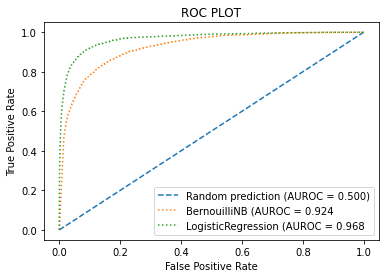

In [10]:
plot_roc_curve(roccurve,aucscores,random)

INSULT EVALUATION 

In [11]:

scores , aucscores, roccurve, random, f1scores = eval_BERT(xtrain,xvalid,y_insult_train,y_insult_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [12]:
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.5332770804767429
BernoulliNB  :  0.41811210516706226


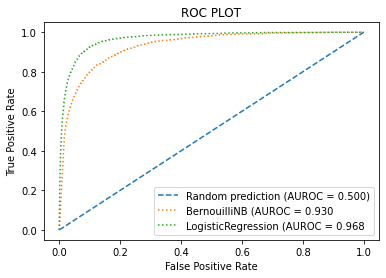

In [13]:
plot_roc_curve(roccurve,aucscores,random)

THREAT EVALUATION

In [14]:
scores , aucscores, roccurve, random, f1scores  = eval_BERT(xtrain,xvalid,y_threat_train,y_threat_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.2765196662693683
BernoulliNB  :  0.060698689956331875


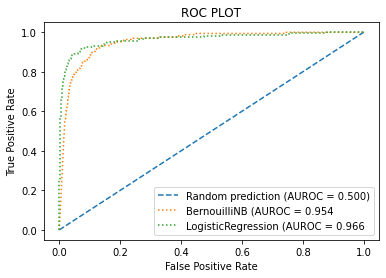

In [16]:
plot_roc_curve(roccurve,aucscores,random)

TOXIC EVALUATION

In [17]:
scores , aucscores, roccurve, random, f1scores= eval_BERT(xtrain,xvalid,y_toxic_train,y_toxic_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [18]:
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.6347186319347783
BernoulliNB  :  0.5152193645990923


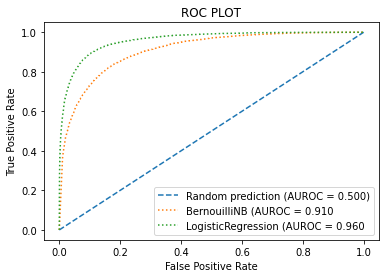

In [19]:
plot_roc_curve(roccurve,aucscores,random)

SEVERE_TOXIC EVALUATION 

In [20]:
scores , aucscores, roccurve, random, f1scores = eval_BERT(xtrain,xvalid,y_severe_toxic_train,y_severe_toxic_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [21]:
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.33664825046040514
BernoulliNB  :  0.18698406603954693


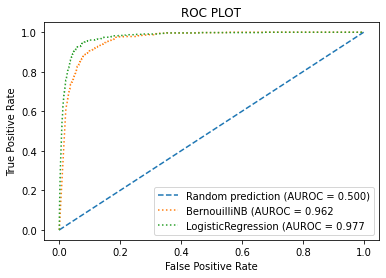

In [22]:
plot_roc_curve(roccurve,aucscores,random)

IDENTITY HATE EVALUATION

In [23]:
scores , aucscores, roccurve, random, f1scores= eval_BERT(xtrain,xvalid,y_identity_hate_train,y_identity_hate_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [24]:
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.2293221857270827
BernoulliNB  :  0.12844036697247704


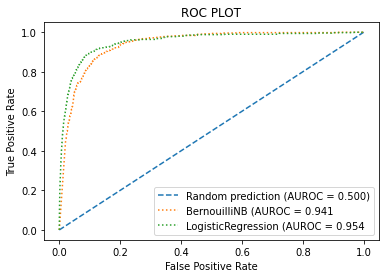

In [25]:
plot_roc_curve(roccurve,aucscores,random)

# Macro Average for Multi Label Classification  on Test set 

In [36]:
from sklearn.metrics import f1_score

y_toxic_test= test_data['toxic'].values
y_severe_toxic_test = test_data['severe_toxic'].values
y_obscene_test = test_data['obscene'].values
y_threat_test = test_data['threat'].values
y_insult_test = test_data['insult'].values
y_identity_hate_test = test_data['identity_hate'].values

with open("/content/drive/MyDrive/CS247/sen_emb_test.pkl", 'rb') as fid:
    xtest =pickle.load(fid)
# X_test = test_data['comment'].tolist()
# xtest = []
# res =[]
# for item in sentence_vec(X_test):
#   res.append(item)

# for item in detach(res):
#     xtest.append(item)


 

In [53]:
def run_threshold_lr(xtrain,xtest,ytrain,ytest,tr):
    lr = LogisticRegression(max_iter =700,class_weight='balanced')
    lr.fit(xtrain,ytrain)
    probabilities = lr.predict_proba(xtest)
    y_pred = (probabilities[:,1] >= tr).astype(int)
    f1 = f1_score(ytest,y_pred)
    return f1

def run_threshold_nb(xtrain,xtest,ytrain,ytest,tr):
    nb = BernoulliNB()
    nb.fit(xtrain,ytrain)
    probabilities = nb.predict_proba(xtest)
    y_pred = (probabilities[:,1] >= tr).astype(int)
    f1 = f1_score(ytest,y_pred)
    return f1


def calculate_scores(xtrain,xtest,ytrain,ytest,res1,res2,res1_tr,res2_tr,label):
    names = ['LogisticRegression','BernoulliNB']
    _,_,_,_,f1scores,thresholds = eval_BERT(xtrain,xtest,ytrain,ytest)
    lr_tr = thresholds['LogisticRegression']
    nb_tr = thresholds['BernoulliNB']
    lr_tr_score = run_threshold_lr(xtrain,xtest,ytrain,ytest,lr_tr)
    nb_tr_score = run_threshold_nb(xtrain,xtest,ytrain,ytest,nb_tr)
    res1[label] = f1scores[names[0]]
    res2[label] = f1scores[names[1]]
    res1_tr[label] = lr_tr_score
    res2_tr[label] =  nb_tr_score


def final_results(res_lr,res_nb,res_tr_lr,res_tr_nb):
    N = 6
    sum_lr = 0
    sum_nb = 0
    sum_tr_lr = 0
    sum_tr_nb = 0
    for key in res_lr:
         sum_lr += res_lr[key]

    for key in res_nb:
        sum_nb += res_nb[key]

    for key in res_tr_lr:
        sum_tr_lr += res_tr_lr[key]

    for key in res_tr_nb:
        sum_tr_nb += res_tr_nb[key]

    f1average_lr  = sum_lr / N
    f1average_nb  = sum_nb / N
    f1average_tr_lr = sum_tr_lr / N
    f1average_tr_nb = sum_tr_nb / N
    return f1average_lr , f1average_nb, f1average_tr_lr , f1average_tr_nb



def run_all_classifiers():
    results_lr = {}
    results_nb = {}
    results_lr_tr = {}
    results_nb_tr = {}
    all_y_test = [y_toxic_test,y_severe_toxic_test,y_obscene_test,y_threat_test,y_insult_test,y_identity_hate_test]
    all_y_train = [y_toxic_train,y_severe_toxic_train,y_obscene_train,y_threat_train,y_insult_train,y_identity_hate_train]
    labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    for i in range(len(all_y_train)):
        calculate_scores(xtrain,xtest,all_y_train[i],all_y_test[i],results_lr,results_nb,results_lr_tr,results_nb_tr,labels[i])
    
    res1,res2,res3,res4 = final_results(results_lr,results_nb,results_lr_tr,results_nb_tr)
    return res1, res2,res3,res4




    



In [54]:
f1average_lr , f1average_nb, f1average_lr_tr , f1average_nb_tr  = run_all_classifiers()
print('Logistic Regression F1 score : ', f1average_lr)
print('BernoulliNB F1 score : ',f1average_nb)
print('Logistic Regression with threshold F1 score :', f1average_lr_tr )
print('BernoulliNB with threshold  F1 score : ',f1average_nb_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression F1 score :  0.3537066435957736
BernoulliNB F1 score :  0.2522834408958118
Logistic Regression with threshold F1 score : 0.28113365510009064
BernoulliNB with threshold  F1 score :  0.22536402847824574


In [ ]:
f1scores , aucscores, roccurve, random = eval_BERT(xtrain,xtest,y_insult_train,y_insult_test)
for key, value in f1scores.items():
    print(key, ' : ', value)

In [ ]:
f1scores , aucscores, roccurve, random = eval_BERT(xtrain,xtest,y_threat_train,y_threat_test)
for key, value in f1scores.items():
    print(key, ' : ', value)

In [ ]:
f1scores , aucscores, roccurve, random = eval_BERT(xtrain,xtest,y_toxic_train,y_toxic_test)
for key, value in f1scores.items():
    print(key, ' : ', value)

In [ ]:
f1scores , aucscores, roccurve, random = eval_BERT(xtrain,xtest,y_severe_toxic_train,y_severe_toxic_test)
for key, value in f1scores.items():
    print(key, ' : ', value)

In [ ]:
f1scores , aucscores, roccurve, random = eval_BERT(xtrain,xtest,y_identity_hate_train,y_identity_hate_test)
for key, value in f1scores.items():
    print(key, ' : ', value)

Display Results 

In [ ]:
print('Logisitic regression Macro Av F1 score: ')
print('Bernoulli Naive Bayes Macro Av F1 score: ')